In [2]:
#importing libraries 
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import skbio
import skbio.diversity
import skbio.stats.composition
import scipy
import pylab as pl
import statsmodels.api as sm

%matplotlib inline

import arivale_data_interface as adi
# apply settings so the lib knows where the data is
adi.apply_isb_config()

#list the local snapshots
local_snapshots = adi.list_local_snapshots()
print(len(local_snapshots))
local_snapshots[0]

# ignore deprecation warnings
import warnings
warnings.filterwarnings('ignore')

98


In [3]:
#read in ASV table
asvs = pd.read_csv("/proj/arivale/microbiome/16S_processed/asvs.csv")

#read in samples metadata
samples = pd.read_csv("/proj/arivale/microbiome/16S_processed/metadata.csv")

#read in taxonomy data
tax = pd.read_csv("/proj/arivale/microbiome/16S_processed/taxonomy.csv")

#load in chemistries snapshot 
chemistries = adi.get_snapshot('chemistries')

#load in lifestyle_assessments snapshot  
lifestyle_assessment = adi.get_snapshot('assessments_raw')

#load in medications_assessments snapshot 
medications = adi.get_snapshot('assessments_medications')
#only include patients who have not taken antibiotics in the last three months 
no_antibiotics = medications[medications['meds_antibiotics_last_3_months'].isin(['No'])]

#import Shannon diversity
shannon_trimmed = adi.get_snapshot('microbiome_trimmed_diversity')
shannon = adi.get_snapshot('microbiome_diversity')

In [5]:
# view head size of dataframe containing all samples
all_samples = samples.copy(deep=True)
all_samples_ids = all_samples['id'].values
all_samples.head()
all_samples.shape

(5232, 24)

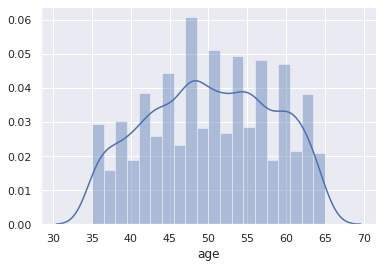

In [6]:
#merge samples with antibiotics data
samples_noab = pd.merge(all_samples,no_antibiotics[['public_client_id',
                                                           'meds_antibiotics_last_3_months',]],on='public_client_id')

#filter out ages in the outside range
samples_over35 = samples_noab[samples_noab['age'] >=35]
age_filtered_samples = samples_over35[samples_over35['age'] <= 65]
age_filtered_samples.shape
sns.distplot(age_filtered_samples['age'])

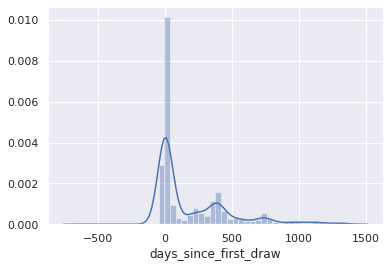

In [7]:
# distribution of days since first blood draw
sns.distplot(age_filtered_samples['days_since_first_draw'])

In [8]:
#filter for checkpoint1 samples (30 days or less)
baseline_samples = age_filtered_samples.copy(deep=True)
baseline_samples['days_since_first_draw_abs'] = baseline_samples['days_since_first_draw'].abs()
baseline_samples = baseline_samples[baseline_samples['days_since_first_draw'].abs() <= 30]
ckpt1_samples = baseline_samples.sort_values('days_since_first_draw_abs').groupby('public_client_id').first()

#filter for baseline chemistries
ckpt1_chemistries = chemistries[chemistries['days_since_first_draw'].abs() <= 30]

#merge with HbA1C data
ckpt1_metadata = pd.merge(ckpt1_samples,ckpt1_chemistries[['public_client_id','GLYCOHEMOGLOBIN A1C']],on='public_client_id')


#only include HbA1C levels above the healthy HbA1C threshold
ckpt1_metadata = ckpt1_metadata[ckpt1_metadata['GLYCOHEMOGLOBIN A1C']>=5.0]
ckpt1_metadata.shape


(1897, 27)

In [9]:
#rename 'days since first draw' column to 'time point'
ckpt1_metadata = ckpt1_metadata.rename(columns={'days_since_first_draw': 'time point'})

#replace all values in the time point column with 0
ckpt1_metadata['time point'] = np.where(ckpt1_metadata['time point'] <= 30, 0, 
                                                ckpt1_metadata['time point'])


In [11]:
#filter for checkpoint2 samples (~6months)
samples2 = age_filtered_samples.copy(deep=True)
samples2['days_since_first_draw_abs'] = samples2['days_since_first_draw'].abs()
samples2 = samples2[samples2['days_since_first_draw'].abs() <= 400]
ckpt2_samples = samples2[samples2['days_since_first_draw'].abs() >180]
ckpt2_samples = ckpt2_samples.sort_values('days_since_first_draw_abs').groupby('public_client_id').first()
#sixmonth_samples_ids = sixmonth_samples['id'].values


ckpt2_samples.shape

(607, 25)

In [12]:
#only indlude six month blood draw data for chemistries
baseline_chemistries2 = chemistries.copy(deep=True)
baseline_chemistries2 = baseline_chemistries2[baseline_chemistries2['days_since_first_draw'].abs() <= 400]
ckpt2_chemistries = baseline_chemistries2[baseline_chemistries2['days_since_first_draw'].abs() >180]
ckpt2_chemistries.shape

#merge with insulin data
ckpt2_metadata = pd.merge(ckpt2_samples,ckpt2_chemistries[['public_client_id','GLYCOHEMOGLOBIN A1C']],on='public_client_id')

ckpt2_metadata.shape

(769, 27)

In [13]:
ckpt2_metadata = ckpt2_metadata.rename(columns={'days_since_first_draw': 'time point'})
ckpt2_metadata['time point'] = np.where(ckpt2_metadata['time point'] <= 400, 6, 
                                                ckpt2_metadata['time point'])

In [14]:
#convert bl_metadata from longform to wide form
ckpt1_long = pd.melt(ckpt1_metadata,id_vars=['public_client_id','time point'],value_vars=['GLYCOHEMOGLOBIN A1C'])
ckpt1_long =ckpt1_long.drop(['variable'],axis=1)

In [15]:
#convert sixmonth_metadata from longform to wide form
ckpt2_long = pd.melt(ckpt2_metadata,id_vars=['public_client_id','time point'],value_vars=['GLYCOHEMOGLOBIN A1C'])
ckpt2_long =ckpt2_long.drop(['variable'],axis=1)

In [16]:
#combine baseline and sixmonth metadata
ckptALL_long = [ckpt1_long,ckpt2_long]
ckptALL_longdata = pd.concat(ckptALL_long)
ckptALL_longdata = ckptALL_longdata.rename(columns={'value':'HbA1C'})

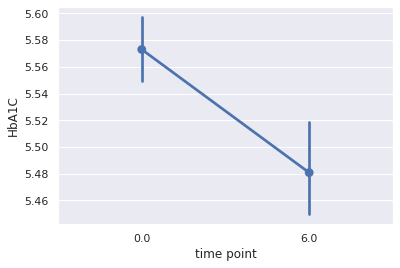

In [17]:
# change in HbA1C levels between two checkpoints
sns.pointplot(x='time point',y='HbA1C',data=ckptALL_longdata)

In [18]:
#rename 'HBA1C' column to 'BL_HBA1C' in bl_metadata2 dataframe
ckpt1_metadata2 = ckpt1_metadata.rename({'time point':'BL_time_point','GLYCOHEMOGLOBIN A1C':'BL_HbA1C'},axis=1)
ckpt1_metadata2.shape

(1897, 27)

In [19]:
# rename 'HBA1C' column to '2nd_HBA1C' in sixmonth_metadata2 dataframe
ckpt2_metadata2 = ckpt2_metadata.rename({'time point':'2nd_time_point','GLYCOHEMOGLOBIN A1C':'2nd_HbA1C'},axis=1)
ckpt2_metadata2.shape

(769, 27)

In [20]:
#create dataframe of baseline and 6 month insulin data
ckptALL_metadata = pd.merge(ckpt1_metadata2,ckpt2_metadata2[['public_client_id','2nd_time_point','2nd_HbA1C']],
                          on='public_client_id')
#bl6mo_metadata = bl6mo_metadata['BL_INSULIN'].dropna()
ckptALL_metadata['public_client_id'].nunique()
ckptALL_metadata.head()
unique_ckptALL_metadata = ckptALL_metadata.drop_duplicates('public_client_id')
unique_ckptALL_metadata['public_client_id'].nunique()
unique_ckptALL_metadata.shape

(450, 29)

In [21]:
################################
# DELTA CALCULATION
# create empty list for change in HbA1C
Delta = []

# create for loop that 
for row1 in unique_ckptALL_metadata['BL_HbA1C']:
    for row2 in unique_ckptALL_metadata['2nd_HbA1C']:
        Delta.append(row1 - row2)

# absolute value of delta        
Delta_abs = [abs(ele) for ele in Delta]

# add delta column to BL and 6 month metadata
unique_ckptALL_metadata['Delta'] = Delta_abs[0:450]
#len(Delta_abs)
unique_ckptALL_metadata.head()

public_client_id      genome_id genome_vendor multiple_genome_ids  \
0         01004596      DS-267294      NEXTCODE                 NaN   
2         01005100      DS-293608      WUXI_SNP                 NaN   
3         01005890      DS-243921      NEXTCODE                 NaN   
4         01006695      DS-291353      WUXI_SNP                 NaN   
5         01006974  A941AR682-005      NEXTCODE                 NaN   

   client_id                               user_id sex   race  \
0   162347.0  81043448-c215-489d-ac48-4e11113f82a2   F  white   
2   268339.0  ec9e8086-1f28-44e8-81f8-f4732d6bda1c   F  white   
3   135726.0  659c5b87-e32f-4b15-98fc-81e995e347bd   M  asian   
4   253022.0  c17dcc57-022d-483e-b3be-1386820f5e19   M  white   
5      327.0  0aba2f91-f7fc-4731-b425-72f3c5d1926a   M  white   

   has_research_consent        enterprise  ... BL_time_point month weekday  \
0                  True  ce0cf55cf4a60dd0  ...           0.0   Feb     Mon   
2                  True  aac0298a21469db8  ...           0.0   Apr     Mon   
3                  True  f89affb34da2473b  ...           0.0   Jul     Fri   
4                  True  f1c39fea488575ec  ...           0.0   Mar     Mon   
5                  True  d4cd0dabcf4caa22  ...           0.0   Jul     Tue   

                            id meds_antibiotics_last_3_months  \
0  22001612561407|GFM-1079-001                             No   
2  22001803512697|GFM-1079-024                             No   
3             AV15-3836|AKE025                             No   
4  22001701510224|GFM-1079-022                             No   
5             AV15-1038|AKE007                             No   

   days_since_first_draw_abs  BL_HbA1C 2nd_time_point  2nd_HbA1C  Delta  
0                        3.0       5.5            6.0        5.5    0.0  
2                       10.0       5.4            6.0        5.2    0.3  
3                        6.0       5.6            6.0        5.8    0.3  
4                        3.0       5.4            6.0        5.5    0.0  
5                        0.0       5.1            6.0        5.4    0.1  

[5 rows x 30 columns]

In [22]:
# intermediate dataframe before normally distribution of delta values
# drop zero and infinity values from delta column 
int_dataframe = unique_ckptALL_metadata.copy(deep=True)
int_dataframe.head()

public_client_id      genome_id genome_vendor multiple_genome_ids  \
0         01004596      DS-267294      NEXTCODE                 NaN   
2         01005100      DS-293608      WUXI_SNP                 NaN   
3         01005890      DS-243921      NEXTCODE                 NaN   
4         01006695      DS-291353      WUXI_SNP                 NaN   
5         01006974  A941AR682-005      NEXTCODE                 NaN   

   client_id                               user_id sex   race  \
0   162347.0  81043448-c215-489d-ac48-4e11113f82a2   F  white   
2   268339.0  ec9e8086-1f28-44e8-81f8-f4732d6bda1c   F  white   
3   135726.0  659c5b87-e32f-4b15-98fc-81e995e347bd   M  asian   
4   253022.0  c17dcc57-022d-483e-b3be-1386820f5e19   M  white   
5      327.0  0aba2f91-f7fc-4731-b425-72f3c5d1926a   M  white   

   has_research_consent        enterprise  ... BL_time_point month weekday  \
0                  True  ce0cf55cf4a60dd0  ...           0.0   Feb     Mon   
2                  True  aac0298a21469db8  ...           0.0   Apr     Mon   
3                  True  f89affb34da2473b  ...           0.0   Jul     Fri   
4                  True  f1c39fea488575ec  ...           0.0   Mar     Mon   
5                  True  d4cd0dabcf4caa22  ...           0.0   Jul     Tue   

                            id meds_antibiotics_last_3_months  \
0  22001612561407|GFM-1079-001                             No   
2  22001803512697|GFM-1079-024                             No   
3             AV15-3836|AKE025                             No   
4  22001701510224|GFM-1079-022                             No   
5             AV15-1038|AKE007                             No   

   days_since_first_draw_abs  BL_HbA1C 2nd_time_point  2nd_HbA1C  Delta  
0                        3.0       5.5            6.0        5.5    0.0  
2                       10.0       5.4            6.0        5.2    0.3  
3                        6.0       5.6            6.0        5.8    0.3  
4                        3.0       5.4            6.0        5.5    0.0  
5                        0.0       5.1            6.0        5.4    0.1  

[5 rows x 30 columns]

In [23]:
# replace all 0 values with NaN (because you can't take the log of 0)
int_dataframe['Delta'].replace(0,np.nan,inplace=True)

In [25]:
# drop all NaN values
no_na = int_dataframe.dropna(subset=['Delta'])
no_na.shape

(380, 30)

In [26]:
#normalized delta values by taking the log value
normal_delta = np.log10(no_na['Delta'])

In [27]:
len(normal_delta)

380

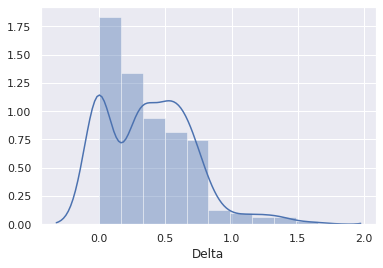

In [28]:
#add +1 to all values
normal_delta = normal_delta+1
sns.distplot(normal_delta)

In [29]:
no_na.shape

(380, 30)

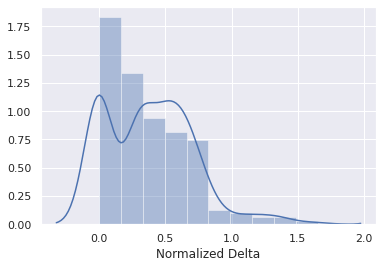

In [30]:
# add normalized delta to table
no_na['Normalized Delta'] = normal_delta[0:380]
sns.distplot(no_na['Normalized Delta'])

In [31]:
normalized_data = no_na.copy()
normalized_data.describe()

client_id         age  days_in_program  days_since_first_call  \
count     380.000000  380.000000       380.000000             379.000000   
mean   122538.139474   51.271053        24.342105               0.065963   
std     95902.335383    7.972426        25.163818              21.708467   
min       237.000000   35.000000         1.000000            -182.000000   
25%       667.750000   46.000000         9.000000              -7.000000   
50%    164926.500000   52.000000        16.000000               0.000000   
75%    185891.500000   57.000000        29.250000               6.000000   
max    275907.000000   65.000000       162.000000             148.000000   

       BL_time_point  days_since_first_draw_abs    BL_HbA1C  2nd_time_point  \
count          380.0                 380.000000  380.000000           380.0   
mean             0.0                   5.421053    5.569211             6.0   
std              0.0                   6.838628    0.579532             0.0   
min              0.0                   0.000000    5.000000             6.0   
25%              0.0                   0.000000    5.300000             6.0   
50%              0.0                   3.000000    5.500000             6.0   
75%              0.0                   9.000000    5.700000             6.0   
max              0.0                  29.000000   10.500000             6.0   

        2nd_HbA1C       Delta  Normalized Delta  
count  380.000000  380.000000      3.800000e+02  
mean     5.539474    0.342105      3.837259e-01  
std      0.544456    0.425029      3.295321e-01  
min      4.200000    0.100000     -1.554312e-15  
25%      5.200000    0.100000     -1.554312e-15  
50%      5.400000    0.200000      3.010300e-01  
75%      5.700000    0.400000      6.020600e-01  
max     10.000000    4.500000      1.653213e+00

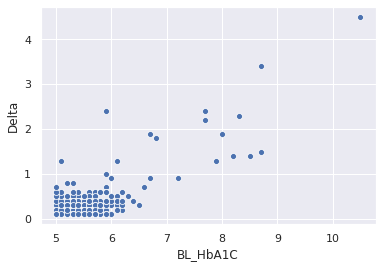

In [32]:
sns.scatterplot(data=normalized_data, x='BL_HbA1C',y='Delta')

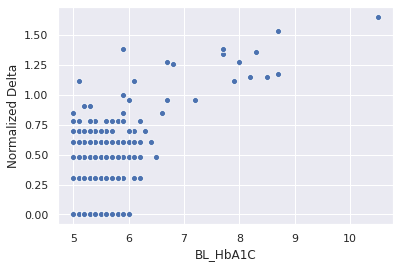

In [33]:
sns.scatterplot(data=normalized_data, x='BL_HbA1C',y='Normalized Delta')

In [34]:
##################################
# LINEAR REGRESSION USING STATSMODELS - GETTING RESIDUALS FOR CONT MODELS

In [35]:
normalized_data = normalized_data.rename(columns={'Normalized Delta':'Delta2'})

In [36]:
import statsmodels.api as sm

In [37]:
from statsmodels.formula.api import ols

In [38]:
# linear regression to fit baseline HbA1C levels to delta values
delta_model = ols('Delta ~ BL_HbA1C', data=normalized_data).fit()

In [39]:
# get residuals
continuous_residuals = delta_model.resid

In [40]:
# print summary
print(delta_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Delta   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     433.8
Date:                Thu, 20 Aug 2020   Prob (F-statistic):           1.02e-64
Time:                        16:10:52   Log-Likelihood:                -68.340
No. Observations:                 380   AIC:                             140.7
Df Residuals:                     378   BIC:                             148.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6437      0.144    -18.343      0.0

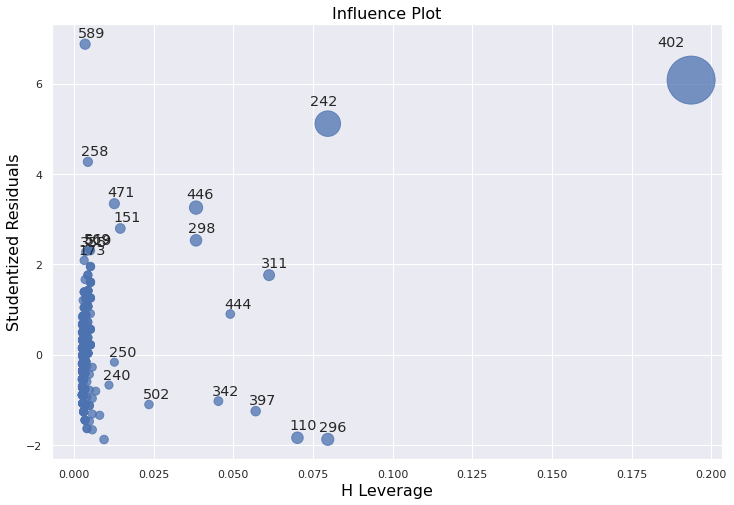

In [41]:
# influence plot
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(delta_model, ax=ax, criterion='cooks')

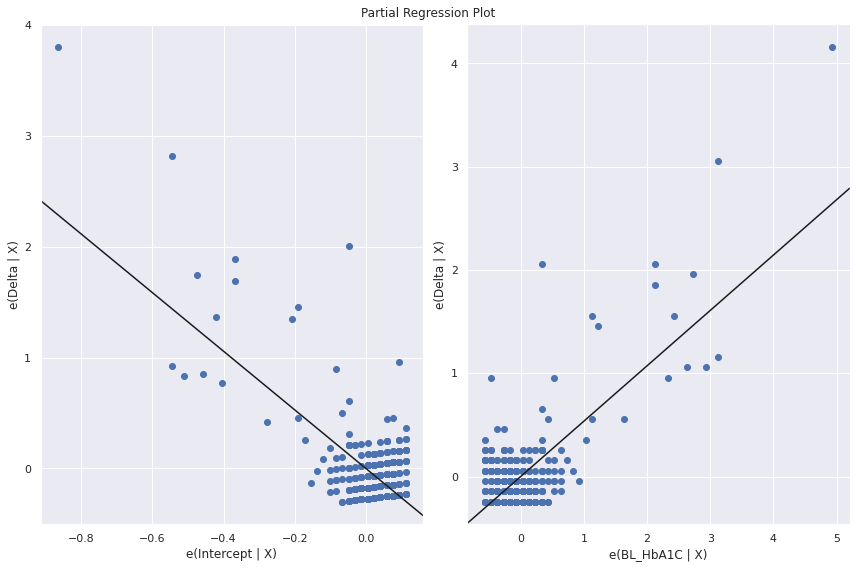

In [42]:
# partial regression plot
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(delta_model, fig=fig)

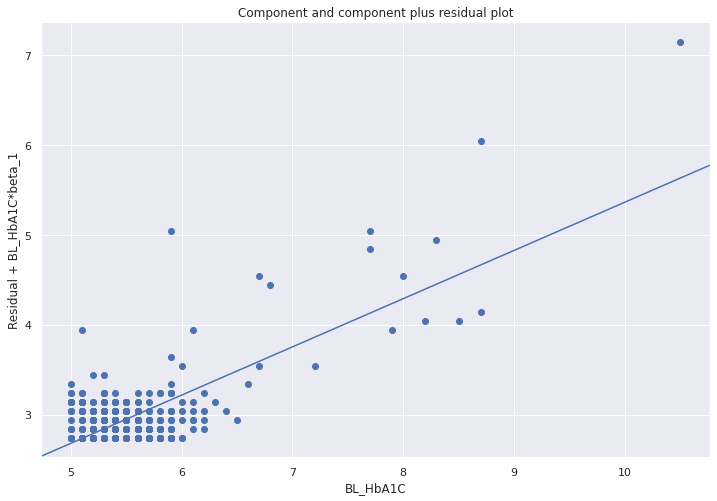

In [43]:
# componenet plus residual plot
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.plot_ccpr(delta_model, 'BL_HbA1C',ax=ax)

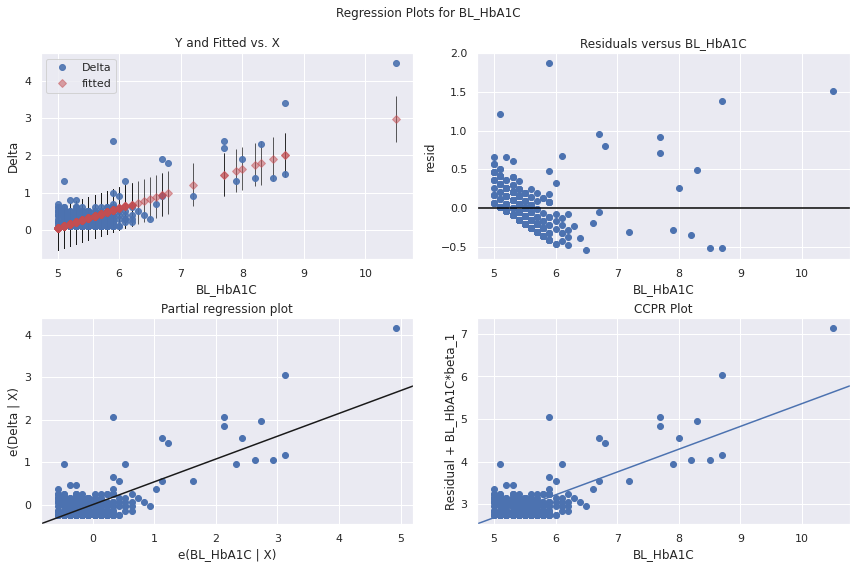

In [44]:
# more regression plots
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(delta_model, 'BL_HbA1C',fig=fig)

In [46]:
# influence
influence = delta_model.get_influence()

In [47]:
# leverage
leverage = influence.hat_matrix_diag

In [48]:
# cooks distance
cooks_d = influence.cooks_distance

In [49]:
# standardized residuals
standardized_residuals = influence.resid_studentized_internal

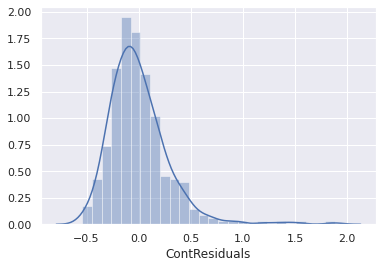

In [50]:
#add residuals to table
normalized_data['ContResiduals'] = continuous_residuals
sns.distplot(normalized_data['ContResiduals'])

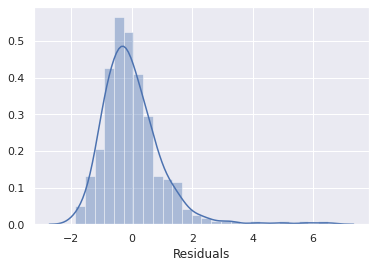

In [54]:
# add standardized residuals to data
normalized_data['Residuals'] = standardized_residuals
sns.distplot(normalized_data['Residuals'])

In [55]:
normalized_data.head()

public_client_id      genome_id genome_vendor multiple_genome_ids  \
2         01005100      DS-293608      WUXI_SNP                 NaN   
3         01005890      DS-243921      NEXTCODE                 NaN   
5         01006974  A941AR682-005      NEXTCODE                 NaN   
6         01008097      DS-269522      NEXTCODE                 NaN   
7         01011802  A042AU490-007      NEXTCODE                 NaN   

   client_id                               user_id sex              race  \
2   268339.0  ec9e8086-1f28-44e8-81f8-f4732d6bda1c   F             white   
3   135726.0  659c5b87-e32f-4b15-98fc-81e995e347bd   M             asian   
5      327.0  0aba2f91-f7fc-4731-b425-72f3c5d1926a   M             white   
6   164967.0  143086a9-813c-412b-b5d9-18c41181b143   M  ashkenazi jewish   
7      736.0  a0839f01-3fcb-4955-8739-96b8dc55cb22   F             asian   

   has_research_consent        enterprise  ...                           id  \
2                  True  aac0298a21469db8  ...  22001803512697|GFM-1079-024   
3                  True  f89affb34da2473b  ...             AV15-3836|AKE025   
5                  True  d4cd0dabcf4caa22  ...             AV15-1038|AKE007   
6                  True  ce0cf55cf4a60dd0  ...  22001612561622|GFM-1079-003   
7                  True  d4cd0dabcf4caa22  ...             AV15-1478|AKE009   

  meds_antibiotics_last_3_months days_since_first_draw_abs BL_HbA1C  \
2                             No                      10.0      5.4   
3                             No                       6.0      5.6   
5                             No                       0.0      5.1   
6                             No                       1.0      5.8   
7                             No                       0.0      5.0   

  2nd_time_point  2nd_HbA1C  Delta        Delta2  ContResiduals  Residuals  
2            6.0        5.2    0.3  4.771213e-01       0.048612   0.167630  
3            6.0        5.8    0.3  4.771213e-01      -0.058612  -0.202091  
5            6.0        5.4    0.1 -1.554312e-15       0.009448   0.032604  
6            6.0        5.7    0.2  3.010300e-01      -0.265836  -0.916777  
7            6.0        5.6    0.1 -1.554312e-15       0.063060   0.217705  

[5 rows x 33 columns]

Text(0.5, 1.0, 'HbA1C: Response to Intervention')

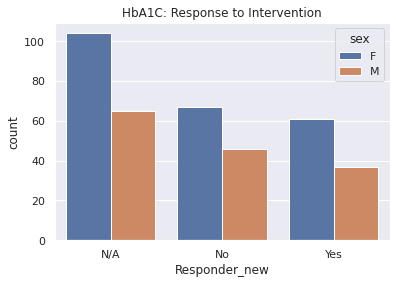

In [57]:
# create empty list for responder data 
Responder = []

for delta in normalized_data['Residuals']: 
    if delta >= 0.453455:
        Responder.append('Yes')
    elif delta <= -0.532982:
        Responder.append('No')
    else:
        Responder.append('N/A')
        

#add responder column to BL and 6 month metadata
normalized_data['Responder_new'] = Responder[0:380]
sns.countplot(x='Responder_new',data=normalized_data, hue='sex')
plt.title('HbA1C: Response to Intervention')

In [58]:
# drop all unecessary columns in metadata dataframe
metadata = normalized_data.drop(['genome_id','genome_vendor','coach','multiple_genome_ids','client_id','user_id','race','enterprise',
    'region','country','current_program','latest_program','is_helix','vendor_observation_id','days_in_program',
     'days_since_first_call','month','weekday'],axis=1)
#rename 'id' column to 'sample id'
metadata = metadata.rename({'id':'sample_id'},axis=1)

In [59]:
# diversity data
shannon_compact = shannon_trimmed.groupby(['public_client_id']).mean()
shannon_compact_reset = shannon_compact.reset_index()
shannon_compact_reset.head()

public_client_id  days_in_program  days_since_first_call  \
0         01000261             77.0                    3.0   
1         01001298             16.0                    9.0   
2         01001621            186.0                  144.0   
3         01001661             20.0                    6.0   
4         01001798             12.0                    7.0   

   days_since_first_draw  diversity_PD_whole_tree  diversity_chao1  \
0                   12.0                   56.731         1750.564   
1                    9.0                   39.766         1311.988   
2                  175.0                   37.867         1163.864   
3                   -4.0                   41.708         1251.796   
4                    9.0                   41.089         1351.188   

   diversity_observed_otus  diversity_shannon  diversity_simpson  \
0                   1168.6           4.313455              0.957   
1                    789.0           3.995993              0.950   
2                    751.0           3.890635              0.952   
3                    801.6           3.885090              0.942   
4                    890.7           4.106897              0.966   

   PD_whole_tree_20000  ...  PD_whole_tree_50000  chao1_50000  \
0               44.715  ...               56.731     1750.564   
1               30.724  ...               39.766     1311.988   
2               30.099  ...               37.867     1163.864   
3               31.616  ...               41.708     1251.796   
4               30.811  ...               41.089     1351.188   

   observed_otus_50000  shannon_50000  simpson_50000  PD_whole_tree_100000  \
0               1168.6       4.313455          0.957                67.216   
1                789.0       3.995993          0.950                48.788   
2                751.0       3.890635          0.952                44.966   
3                801.6       3.885090          0.942                   NaN   
4                890.7       4.106897          0.966                49.575   

   chao1_100000  observed_otus_100000  shannon_100000  simpson_100000  
0      2096.408                1515.2        4.324545           0.957  
1      1625.145                1057.6        4.005004           0.951  
2      1458.496                 967.2        3.892715           0.952  
3           NaN                   NaN             NaN             NaN  
4      1622.996                1152.2        4.108976           0.965  

[5 rows x 29 columns]

In [60]:
#merge diversity data to compact metadata
metadata_diversity = pd.merge(metadata,shannon_compact_reset[['public_client_id','shannon_50000']],
                                  on='public_client_id')
metadata_diversity.shape

(380, 17)

In [61]:
# load in snapshot with bmi data
BMI = adi.get_snapshot('weight_raw')
BMI_compact = BMI.groupby('public_client_id').mean()
BMI_compact = BMI_compact.reset_index()
BMI_compact.shape

(5735, 12)

In [62]:
# merge with BMI data with metadata_diversity data
metadata_diversity_BMI = pd.merge(metadata_diversity, BMI_compact[['public_client_id','BMI']], 
                                  on='public_client_id')

metadata_diversity_BMI['public_client_id'].nunique()

380

In [63]:
# load in vendor data
#read in microbiome data with vendor info
vendors = adi.get_snapshot('microbiome_trimmed_sample_stats')
vendors = vendors[['public_client_id','vendor']].copy()
vendors_compact = vendors.drop_duplicates('public_client_id')
vendors_compact.shape

(3696, 2)

In [64]:
# merge vendor data
metadata_div_BMI_ven = pd.merge(metadata_diversity_BMI,vendors_compact,on='public_client_id')
metadata_div_BMI_ven['public_client_id'].nunique()
metadata_div_BMI_ven.head()

public_client_id sex  has_research_consent   age  BL_time_point  \
0         01005100   F                  True  48.0            0.0   
1         01005890   M                  True  42.0            0.0   
2         01006974   M                  True  57.0            0.0   
3         01008097   M                  True  59.0            0.0   
4         01011802   F                  True  40.0            0.0   

                     sample_id meds_antibiotics_last_3_months  \
0  22001803512697|GFM-1079-024                             No   
1             AV15-3836|AKE025                             No   
2             AV15-1038|AKE007                             No   
3  22001612561622|GFM-1079-003                             No   
4             AV15-1478|AKE009                             No   

   days_since_first_draw_abs  BL_HbA1C  2nd_time_point  2nd_HbA1C  Delta  \
0                       10.0       5.4             6.0        5.2    0.3   
1                        6.0       5.6             6.0        5.8    0.3   
2                        0.0       5.1             6.0        5.4    0.1   
3                        1.0       5.8             6.0        5.7    0.2   
4                        0.0       5.0             6.0        5.6    0.1   

         Delta2  ContResiduals  Residuals Responder_new  shannon_50000  \
0  4.771213e-01       0.048612   0.167630           N/A       3.605405   
1  4.771213e-01      -0.058612  -0.202091           N/A       3.971387   
2 -1.554312e-15       0.009448   0.032604           N/A       3.975892   
3  3.010300e-01      -0.265836  -0.916777            No       4.271404   
4 -1.554312e-15       0.063060   0.217705           N/A       3.805378   

         BMI         vendor  
0  23.078283     DNAgenotek  
1  23.024428  Second Genome  
2  24.531480  Second Genome  
3  30.885079     DNAgenotek  
4  21.706497  Second Genome

In [65]:
###########################################################################################
# SETTING UP ASV AND TAXONOMY DATA

In [66]:
#convert ASV table to wide form
asvs_wide=pd.pivot_table(asvs,index='id',columns='hash',values='count', fill_value=0)
asvs_wide_baseline = asvs_wide.loc[asvs_wide.index.isin(all_samples_ids)]

In [67]:
#transpose the asv dataframe
asvsT = asvs_wide_baseline.transpose()
asvsT.head()

id                                22001612560009|GFM-1079-007  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560012|GFM-1079-011  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560014|GFM-1079-016  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560015|GFM-1079-015  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560016|GFM-1079-001  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560017|GFM-1079-009  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560020|GFM-1079-003  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560022|GFM-1079-006  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560023|GFM-1079-001  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66

In [68]:
#add index to newly transposed asv_samples data
asvsT_index = asvsT.reset_index()
asvsT_index.head()

id                              hash  22001612560009|GFM-1079-007  \
0   00002d83dec0ceabeb1fe4135a2b6ab8                            0   
1   00018b0d514b0f1a47ce15eaa4d247f6                            0   
2   0001eda93a1e6802360bf98488c24869                            0   
3   0002120f916215b077ef0a08d66d2716                            0   
4   00030c11306e21d37b6746c3bde4bf04                            0   

id  22001612560012|GFM-1079-011  22001612560014|GFM-1079-016  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

id  22001612560015|GFM-1079-015  22001612560016|GFM-1079-001  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

id  22001612560017|GFM-1079-009  22001612560020|GFM-1079-003  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

id  22001612560022|GFM-1079-006  22001612560023|GFM-1079-001  ...  \
0                             0                            0  ...   
1                             0                            0  ...   
2                             0                            0  ...   
3                             0                            0  ...   
4                             0                            0  ...   

id  AV15-4413|AKE035  AV15-4415|AKE035  CEEX|AKE014  FLCK|AKE014  MIFN|AKE014  \
0                  0                 0            0            0            0   
1                  0                 0            0            0            0   
2                  0                 0            0            0            0   
3                  0                 0            0            0            0   
4                  0                 0            0            0            0   

id  MUMA|AKE014  NEBZ-2|AKE016  NEBZ|AKE014  QIRL-2|AKE014  QIRL|AKE014  
0             0              0            0              0            0  
1             0              0            0              0            0  
2             0              0            0              0            0  
3             0              0            0              0            0  
4             0              0            0              0            0  

[5 rows x 5233 columns]

In [69]:
#taxonomy data: rename the id column to "index" so it can be merged with the asvsamplesT_index dataframe
tax = tax.rename(columns={'id': 'hash'})
tax.head()

Kingdom         Phylum        Class          Order           Family  \
0  Bacteria  Bacteroidetes  Bacteroidia  Bacteroidales   Bacteroidaceae   
1  Bacteria     Firmicutes   Clostridia  Clostridiales  Ruminococcaceae   
2  Bacteria     Firmicutes   Clostridia  Clostridiales  Lachnospiraceae   
3  Bacteria  Bacteroidetes  Bacteroidia  Bacteroidales   Bacteroidaceae   
4  Bacteria     Firmicutes   Clostridia  Clostridiales  Lachnospiraceae   

              Genus      Species  \
0       Bacteroides     vulgatus   
1  Faecalibacterium  prausnitzii   
2      Agathobacter          NaN   
3       Bacteroides          NaN   
4           Blautia          NaN   

                                            sequence  \
0  GCAGCAGTGAGGAATATTGGTCAATGGGCGAGAGCCTGAACCAGCC...   
1  GCAGCAGTGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCG...   
2  GCAGCAGTGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCG...   
3  GCAGCAGTGAGGAATATTGGTCAATGGGCGATGGCCTGAACCAGCC...   
4  GCAGCAGTGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCG...   

                               hash  
0  c2d3fc09212e226b3a2c3398a1af9436  
1  a425c9ccfd2d87768c9524f0a798ee2d  
2  11e733f60337e5ef6c9a94a66841d20b  
3  7ed48cd35b68995ff96e23b89c9018c5  
4  2582ff55b130be55a786156c3da4dcf8

In [70]:
#merge taxonomy data with asv data
ASV_tax_data = pd.merge(asvsT_index,tax,on='hash')
ASV_tax_data.head()

hash  22001612560009|GFM-1079-007  \
0  00002d83dec0ceabeb1fe4135a2b6ab8                            0   
1  00018b0d514b0f1a47ce15eaa4d247f6                            0   
2  0001eda93a1e6802360bf98488c24869                            0   
3  0002120f916215b077ef0a08d66d2716                            0   
4  00030c11306e21d37b6746c3bde4bf04                            0   

   22001612560012|GFM-1079-011  22001612560014|GFM-1079-016  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   22001612560015|GFM-1079-015  22001612560016|GFM-1079-001  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   22001612560017|GFM-1079-009  22001612560020|GFM-1079-003  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   22001612560022|GFM-1079-006  22001612560023|GFM-1079-001  ...  \
0                            0                            0  ...   
1                            0                            0  ...   
2                            0                            0  ...   
3                            0                            0  ...   
4                            0                            0  ...   

   QIRL-2|AKE014  QIRL|AKE014   Kingdom         Phylum        Class  \
0              0            0  Bacteria     Firmicutes   Clostridia   
1              0            0  Bacteria  Bacteroidetes  Bacteroidia   
2              0            0  Bacteria     Firmicutes   Clostridia   
3              0            0  Bacteria     Firmicutes   Clostridia   
4              0            0  Bacteria     Firmicutes   Clostridia   

           Order               Family                          Genus  Species  \
0  Clostridiales      Lachnospiraceae                   Anaerostipes      NaN   
1  Bacteroidales       Muribaculaceae                            NaN      NaN   
2  Clostridiales  Christensenellaceae  Christensenellaceae_R-7_group      NaN   
3  Clostridiales      Ruminococcaceae                            NaN      NaN   
4  Clostridiales      Ruminococcaceae                         DTU089      NaN   

                                            sequence  
0  GCAGCAGTGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCG...  
1  GCAGCAGTGAGGAATATTGGTCAATGGGCGGGAGCCTGAACCAGCC...  
2  GCAGCAGTGGGGAATATTGGGCAATGGGCGAAAGCCTGACCCAGCA...  
3  GCTGCAGTGGGGGATATTGCACAATGGGGGAAACCCTGATGCAGCA...  
4  GCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTGCGTAGGTGGA...  

[5 rows x 5241 columns]

In [71]:
#drop the sequence column
ASV_tax_data = ASV_tax_data.drop(['sequence'],axis=1)

In [72]:
#fill NaN values with 0
ASV_tax_data.fillna(0)

hash  22001612560009|GFM-1079-007  \
0      00002d83dec0ceabeb1fe4135a2b6ab8                            0   
1      00018b0d514b0f1a47ce15eaa4d247f6                            0   
2      0001eda93a1e6802360bf98488c24869                            0   
3      0002120f916215b077ef0a08d66d2716                            0   
4      00030c11306e21d37b6746c3bde4bf04                            0   
...                                 ...                          ...   
89017  fffa9d186997056849b930a68dd8b121                            0   
89018  fffbae09f8a62b3498565b4fe8838846                            0   
89019  fffc51faa053251845837ffc43231b30                            0   
89020  fffe4057d41c6ef3b16a370498eb01a9                            0   
89021  ffff9eed68c63035d7f56c61d7603794                            0   

       22001612560012|GFM-1079-011  22001612560014|GFM-1079-016  \
0                                0                            0   
1                                0                            0   
2                                0                            0   
3                                0                            0   
4                                0                            0   
...                            ...                          ...   
89017                            0                            0   
89018                            0                            0   
89019                            0                            0   
89020                            0                            0   
89021                            0                            0   

       22001612560015|GFM-1079-015  22001612560016|GFM-1079-001  \
0                                0                            0   
1                                0                            0   
2                                0                            0   
3                                0                            0   
4                                0                            0   
...                            ...                          ...   
89017                            0                            0   
89018                            0                            0   
89019                            0                            0   
89020                            0                            0   
89021                            0                            0   

       22001612560017|GFM-1079-009  22001612560020|GFM-1079-003  \
0                                0                            0   
1                                0                            0   
2                                0                            0   
3                                0                            0   
4                                0                            0   
...                            ...                          ...   
89017                            0                            0   
89018                            0                            0   
89019                            0                            0   
89020                            0                            0   
89021                            0                            0   

       22001612560022|GFM-1079-006  22001612560023|GFM-1079-001  ...  \
0                                0                            0  ...   
1                                0                            0  ...   
2                                0                            0  ...   
3                                0                            0  ...   
4                                0                            0  ...   
...                            ...                          ...  ...   
89017                            0                            0  ...   
89018                            0                            0  ...   
89019                            0                            0  ...   
89020                            0 

In [73]:
#sum on genus level
genus_counts = ASV_tax_data.groupby(["Genus"]).sum()
genus_counts.head()

22001612560009|GFM-1079-007  22001612560012|GFM-1079-011  \
Genus                                                                   
1174-901-12                            0                            0   
28-4                                   0                            0   
A2                                     0                            0   
ASF356                                 0                            0   
Abiotrophia                            0                            0   

             22001612560014|GFM-1079-016  22001612560015|GFM-1079-015  \
Genus                                                                   
1174-901-12                            0                            0   
28-4                                   0                            0   
A2                                     0                            0   
ASF356                                 0                            0   
Abiotrophia                            0                            0   

             22001612560016|GFM-1079-001  22001612560017|GFM-1079-009  \
Genus                                                                   
1174-901-12                            0                            0   
28-4                                   0                            0   
A2                                     0                            0   
ASF356                                 0                            0   
Abiotrophia                            0                            0   

             22001612560020|GFM-1079-003  22001612560022|GFM-1079-006  \
Genus                                                                   
1174-901-12                            0                            0   
28-4                                   0                            0   
A2                                     0                            0   
ASF356                                 0                            0   
Abiotrophia                            0                            0   

             22001612560023|GFM-1079-001  22001612560027|GFM-1079-003  ...  \
Genus                                                                  ...   
1174-901-12                            0                            0  ...   
28-4                                   0                            0  ...   
A2                                     0                            0  ...   
ASF356                                 0                            0  ...   
Abiotrophia                            0                            0  ...   

             AV15-4413|AKE035  AV15-4415|AKE035  CEEX|AKE014  FLCK|AKE014  \
Genus                                                                       
1174-901-12                 0                 0            0            0   
28-4                        0               721            0          825   
A2                          0                 0            0            0   
ASF356                      0                 0            0            0   
Abiotrophia                 0                 0            0            0   

             MIFN|AKE014  MUMA|AKE014  NEBZ-2|AKE016  NEBZ|AKE014  \
Genus                                                               
1174-901-12            0            0              0            0   
28-4                   0            0              0            0   
A2                     0            0              0            0   
ASF356                 0            0              0            0   
Abiotrophia            0            0              0            0   

             QIRL-2|AKE014  QIRL|AKE014  
Genus                                    
1174-901-12              0            0  
28-4                   308            0  
A2                       0            0  
ASF356                   0            0  
Abiotrophia              0            0  

[5 rows x 5232 columns]

In [75]:
# filter for genus counts that are greater than or equal to 10; set any NaN values to zero
genus_counts_filtered = genus_counts[genus_counts >= 10].fillna(0)

# filter for genera where abundance > 0. Drop genera (rows) that have a summed abunance of zero
genus_counts_filtered = genus_counts_filtered.loc[genus_counts_filtered.sum(axis=1) > 0,:] 

# filter for samples where the sequencing reads (columns) are greater than 50,000
genus_counts_filtered = genus_counts_filtered.loc[:,genus_counts_filtered.sum() >= 50000]

# add new row that counts number of samples genera is present in
genus_counts_filtered['Total Abundance'] = genus_counts_filtered.gt(0).sum(axis=1)
#genus_counts_filtered['Present in # Samples'] = genus_counts_filtered.where(genus_counts_filtered > 10,0)

# order from most abundant to least abundant
most_abundant_genera = genus_counts_filtered.sort_values(by='Total Abundance',ascending=False)

# look at the top 5% of genera
genus_counts_final = most_abundant_genera.drop(['Total Abundance'],axis=1)

In [76]:
genus_counts_final.shape

(421, 5127)

In [77]:
#NORMALIZING DATA

#normalizing to relative abundance: (count of genus X)/(total count in a sample)
normalized_counts = genus_counts_final/genus_counts_final.sum()
normalized_counts.head()

22001612560009|GFM-1079-007  22001612560012|GFM-1079-011  \
Genus                                                                           
Blautia                                 0.050940                     0.154189   
Bacteroides                             0.244004                     0.194056   
Lachnoclostridium                       0.004237                     0.024900   
Anaerostipes                            0.007820                     0.001366   
Ruminiclostridium_5                     0.022032                     0.013333   

                     22001612560014|GFM-1079-016  22001612560015|GFM-1079-015  \
Genus                                                                           
Blautia                                 0.027534                     0.163810   
Bacteroides                             0.321627                     0.357322   
Lachnoclostridium                       0.018687                     0.087065   
Anaerostipes                            0.012077                     0.029007   
Ruminiclostridium_5                     0.000637                     0.007689   

                     22001612560016|GFM-1079-001  22001612560017|GFM-1079-009  \
Genus                                                                           
Blautia                                 0.110977                     0.037146   
Bacteroides                             0.086270                     0.121887   
Lachnoclostridium                       0.023095                     0.020217   
Anaerostipes                            0.014536                     0.001335   
Ruminiclostridium_5                     0.003224                     0.004500   

                     22001612560020|GFM-1079-003  22001612560022|GFM-1079-006  \
Genus                                                                           
Blautia                                 0.016306                     0.040102   
Bacteroides                             0.705134                     0.152220   
Lachnoclostridium                       0.087545                     0.008037   
Anaerostipes                            0.002998                     0.011453   
Ruminiclostridium_5                     0.000000                     0.017347   

                     22001612560023|GFM-1079-001  22001612560027|GFM-1079-003  \
Genus                                                                           
Blautia                                 0.033234                     0.090414   
Bacteroides                             0.277378                     0.269791   
Lachnoclostridium                       0.013743                     0.017825   
Anaerostipes                            0.004244                     0.025882   
Ruminiclostridium_5                     0.004154                     0.006590   

                     ...  AV15-4413|AKE035  AV15-4415|AKE035  CEEX|AKE014  \
Genus                ...                                                    
Blautia              ...          0.096163          0.080207     0.216629   
Bacteroides          ...          0.045142          0.110624     0.240906   
Lachnoclostridium    ...          0.004683          0.004270     0.018107   
Anaerostipes         ...          0.040379          0.010309     0.021022   
Ruminiclostridium_5  ...          0.003013          0.001598     0.013839   

                     FLCK|AKE014  MIFN|AKE014  MUMA|AKE014  NEBZ-2|AKE016  \
Genus                                                                       
Blautia                 0.022604     0.084686     0.060533       0.073391   
Bacteroides             0.338147     0.191176     0.030755       0.136618   
Lachnoclostridium       0.000811     0.004984     0.012439       0.006218   
Anaerostipes            0.041245     0.040636     0.020138       0.000975   
Ruminiclostridium_5     0.000353     0.000566     0.000304       0.008395   

                     NEBZ|AKE014  QIRL-2|AKE014  QIRL|AKE014  
Genus                                 

In [78]:
######################################################################
# CALCULATING CENTER LOG RATIO FOR ALL DATA

In [79]:
from skbio.stats.composition import clr

In [80]:
# add pseudocount because CLR transform requires that you have non-zero abundances 
normalizedT = skbio.stats.composition.multiplicative_replacement(normalized_counts.T)

# Perform CLR transformation
# https://www.ars.usda.gov/ARSUserFiles/80800505/International%20Workshop/Presentations/Wednesday%20Morning/Adam%20Rivers.pdf

clr_data = skbio.stats.composition.clr(normalizedT)
clr_data = pd.DataFrame(clr_data, 
                        columns = normalized_counts.index, 
                        index = normalized_counts.columns)
clr_data.describe()

Genus      Blautia  Bacteroides  Lachnoclostridium  Anaerostipes  \
count  5127.000000  5127.000000        5127.000000   5127.000000   
mean      7.871255     9.151478           6.360889      6.234284   
std       0.888301     1.249287           1.115900      1.324807   
min      -0.491345    -1.152060          -0.877066     -1.190159   
25%       7.342698     8.712487           5.735619      5.552913   
50%       7.965535     9.313798           6.361809      6.398824   
75%       8.462924     9.882305           7.011708      7.081554   
max      10.632851    11.682056          10.654187      9.590170   

Genus  Ruminiclostridium_5  Butyricicoccus  Faecalibacterium    Roseburia  \
count          5127.000000     5127.000000       5127.000000  5127.000000   
mean              5.027078        5.509925          8.109328     6.433647   
std               1.278988        1.336146          1.668495     1.561885   
min              -1.248095       -1.639180         -1.245811    -1.411845   
25%               4.335592        5.114371          7.960795     5.967638   
50%               5.029493        5.748816          8.493205     6.686212   
75%               5.812477        6.262737          8.894279     7.307272   
max               9.921262        8.893271         10.503367     9.901969   

Genus  Ruminiclostridium_9  Streptococcus  ...  Phocaeicola  Flectobacillus  \
count          5127.000000    5127.000000  ...  5127.000000     5127.000000   
mean              4.794049       4.810550  ...    -1.129309       -1.129512   
std               1.215311       1.762269  ...     0.238505        0.236984   
min              -1.287709      -1.537649  ...    -1.786739       -1.786739   
25%               4.417344       3.856425  ...    -1.291326       -1.291526   
50%               4.938491       4.881140  ...    -1.148522       -1.148549   
75%               5.459984       5.925340  ...    -0.996405       -0.996509   
max               8.327798      10.304052  ...     3.273825        2.826246   

Genus  Diaphorobacter      Dickeya  Planomicrobium    Eikenella  \
count     5127.000000  5127.000000     5127.000000  5127.000000   
mean        -1.129727    -1.128891       -1.129195    -1.129760   
std          0.232239     0.252871        0.242259     0.233053   
min         -1.786739    -1.786739       -1.786739    -1.786739   
25%         -1.291326    -1.291526       -1.291526    -1.291526   
50%         -1.148522    -1.148549       -1.148549    -1.148549   
75%         -0.996405    -0.996509       -0.996405    -0.996405   
max          0.967416     6.342737        4.212421     1.341930   

Genus  Modestobacter        F0058  Flavobacterium  \
count    5127.000000  5127.000000     5127.000000   
mean       -1.129750    -1.129581       -1.129672   
std         0.233598     0.235899        0.233562   
min        -1.786739    -1.786739       -1.786739   
25%        -1.291526    -1.291526       -1.291526   
50%        -1.148549    -1.148549       -1.148522   
75%        -0.996509    -0.996509       -0.996405   
max         1.605412     2.478918        1.580534   

Genus  Candidatus_Methanomethylophilus  
count                      5127.000000  
mean                         -1.130231  
std                           0.230483  
min                          -1.786739  
25%                          -1.291526  
50%                          -1.148549  
75%                          -0.996509  
max                          -0.115579  

[8 rows x 421 columns]

In [81]:
#reset index of clr data and rename index column to 'sample_id'
clr_reset = clr_data.reset_index().rename(columns={'index':'sample_id'})
#clr_reset.head()

In [82]:
#merge compact metadata with clr_data and shannon diversity
clr_metadata_all = pd.merge(clr_reset,metadata_diversity_BMI,on='sample_id')
#clr_metadata_all = clr_metadata_all.groupby('sample_id').mean()
#clr_metadata_all = clr_metadata_all.reset_index()
clr_metadata_all.head()
clr_metadata_all.shape
clr_metadata_all['sample_id'].nunique()

379

In [83]:
# create smaller dataframe of responder baseline gut microbiome
responder_microbiome = clr_metadata_all[clr_metadata_all['Responder_new']=='Yes']
responder_microbiome.shape

(98, 439)

In [84]:
# create smaller dataframe of non-responder baseline gut microbiome
nonresponder_microbiome = clr_metadata_all[clr_metadata_all['Responder_new']=='No']
nonresponder_microbiome.shape
nonresponder_microbiome['sample_id'].nunique()

112

In [85]:
# drop N/A values 
clr_metadata_all['Responder_new'].unique()

array(['Yes', 'No', 'N/A'], dtype=object)

In [86]:
clr_metadata_ML = clr_metadata_all[~clr_metadata_all.Responder_new.str.contains('N/A')]
clr_metadata_ML['Responder_new'].unique()

array(['Yes', 'No'], dtype=object)

In [87]:
clr_metadata_ML = clr_metadata_ML.rename({'Responder_new':'Responder'},axis=1)

Text(0.5, 1.0, 'HbA1C: Response to Intervention')

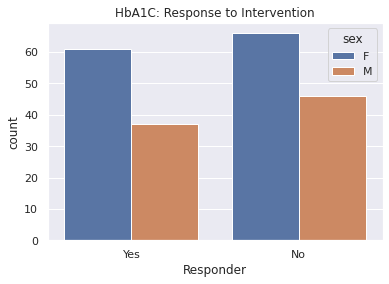

In [88]:
sns.countplot(x='Responder',data=clr_metadata_ML, hue='sex')
plt.title('HbA1C: Response to Intervention')

In [89]:
# create a dummy variable for Sex column in clr_metadata_all (female=1)
gender_ml = pd.get_dummies(clr_metadata_ML['sex'],drop_first=True)

# create a dummy variable for Responder column in clr_metadata_all table (responder=1)
responder_ml = pd.get_dummies(clr_metadata_ML['Responder'],drop_first=True)


# concatenate the dummy variable table with the 
ml_data = pd.concat([clr_metadata_ML,gender_ml,responder_ml,],axis=1)
#list(ml_data.columns)

In [91]:
# drop non-numerical columns
ml_data.drop(['sample_id','public_client_id','has_research_consent','meds_antibiotics_last_3_months',
 'days_since_first_draw_abs','BL_HbA1C','2nd_time_point','BL_time_point','2nd_HbA1C','sex',
              'Delta','Delta2','Residuals','ContResiduals','Responder'],axis=1,inplace=True)
ml_microbiome = ml_data.rename({'Yes':'Responder','M':'Gender'},axis=1).dropna()
ml_microbiome.head()

Blautia  Bacteroides  Lachnoclostridium  Anaerostipes  \
0  8.681723     8.429885           7.111996      6.649005   
1  8.266163     8.473743           5.502707      6.969044   
3  8.634338     9.662676           7.313454      7.629852   
4  8.214528     8.498379           5.144825      5.817390   
5  8.901496     9.091845           5.908650      6.611465   

   Ruminiclostridium_5  Butyricicoccus  Faecalibacterium  Roseburia  \
0             5.143123        6.011111          8.609620   6.942979   
1             6.312963        5.926190          8.285283   7.014164   
3            -0.788380        6.912142          9.416762   7.868132   
4             5.463173        4.595632          8.296337   5.828616   
5             6.288753        5.483233          8.699648   5.994852   

   Ruminiclostridium_9  Streptococcus  ...  Eikenella  Modestobacter  \
0             5.920058       7.127762  ...  -1.203192      -1.203192   
1             4.747039       5.790389  ...  -1.383701      -1.383701   
3            -0.788380       5.370513  ...  -0.788380      -0.788380   
4             4.660045       7.005733  ...  -1.416987      -1.416987   
5             4.168637       6.639610  ...  -1.368535      -1.368535   

      F0058  Flavobacterium  Candidatus_Methanomethylophilus   age  \
0 -1.203192       -1.203192                        -1.203192  42.0   
1 -1.383701       -1.383701                        -1.383701  55.0   
3 -0.788380       -0.788380                        -0.788380  40.0   
4 -1.416987       -1.416987                        -1.416987  47.0   
5 -1.368535       -1.368535                        -1.368535  51.0   

   shannon_50000        BMI  Gender  Responder  
0       4.628490  25.513713       0          1  
1       4.741647  22.617756       1          0  
3       3.690662  23.560357       1          0  
4       4.403217  21.180229       0          1  
5       4.469066  22.942582       0          1  

[5 rows x 426 columns]

In [92]:
# BINARY MODEL 1: LOGISTIC REGRESSION VIA L1 PENALTY

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

In [94]:
#separate X and y variables. y is what you are trying to predict, which in this case is whether a participant is a 
#responder or not

X = ml_microbiome.drop(['Responder'],axis=1)
y = ml_microbiome['Responder']

In [95]:
model_lr = LogisticRegression(penalty='l1',solver='liblinear')

In [96]:
model_lr.fit(X,y)

LogisticRegression(penalty='l1', solver='liblinear')

In [97]:
l1_coefficients = model_lr.coef_[0]
features = X.columns

In [98]:
model1_coefficients = pd.DataFrame({'feature':features,'coefficient':l1_coefficients})

In [99]:
############
# BINARY MODEL 2: RANDOM FOREST REGRESSION

In [100]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [101]:
regressor = RandomForestRegressor(n_estimators=100,random_state=0)

In [102]:
regressor.fit(X,y)

RandomForestRegressor(random_state=0)

In [103]:
# FEATURE IMPORTANCES
feature_importance = regressor.feature_importances_

In [104]:
features = X.columns
importance = feature_importance
rf_importances = pd.DataFrame({'feature':features,'importance':importance})

In [105]:
gut_coef_importances = pd.merge(model1_coefficients,rf_importances,on='feature')
important_gut_genera = gut_coef_importances.sort_values(by='coefficient',ascending=False)

In [106]:
important_gut_genera[0:10]

feature  coefficient  importance
173             Anaeroplasma     1.053468    0.005281
193            Succinivibrio     0.962906    0.001384
272               Arcobacter     0.932307    0.000919
140              Eubacterium     0.879111    0.002387
131  Ruminococcaceae_UCG-011     0.783621    0.007744
20            Flavonifractor     0.720924    0.015588
16          Fusicatenibacter     0.670775    0.014124
191   Prevotellaceae_UCG-001     0.622053    0.000930
215                Rikenella     0.618945    0.000872
161           Asteroleplasma     0.524836    0.027077

In [107]:
clr_metadata_ML = clr_metadata_ML.rename({'Responder_new':'Responder'},axis=1)
clr_metadata_ML.head()

sample_id   Blautia  Bacteroides  Lachnoclostridium  \
0  22001612560016|GFM-1079-001  8.681723     8.429885           7.111996   
1  22001612560099|GFM-1079-003  8.266163     8.473743           5.502707   
3  22001612560121|GFM-1079-012  8.634338     9.662676           7.313454   
4  22001612560126|GFM-1079-011  8.214528     8.498379           5.144825   
5  22001612560131|GFM-1079-004  8.901496     9.091845           5.908650   

   Anaerostipes  Ruminiclostridium_5  Butyricicoccus  Faecalibacterium  \
0      6.649005             5.143123        6.011111          8.609620   
1      6.969044             6.312963        5.926190          8.285283   
3      7.629852            -0.788380        6.912142          9.416762   
4      5.817390             5.463173        4.595632          8.296337   
5      6.611465             6.288753        5.483233          8.699648   

   Roseburia  Ruminiclostridium_9  ...  BL_HbA1C  2nd_time_point  2nd_HbA1C  \
0   6.942979             5.920058  ...       5.3             6.0        4.9   
1   7.014164             4.747039  ...       5.7             6.0        5.6   
3   7.868132            -0.788380  ...       5.5             6.0        5.6   
4   5.828616             4.660045  ...       5.3             6.0        4.9   
5   5.994852             4.168637  ...       5.1             6.0        5.0   

   Delta        Delta2  ContResiduals  Residuals  Responder  shannon_50000  \
0    0.6  7.781513e-01       0.402224   1.387237        Yes       4.628490   
1    0.1 -1.554312e-15      -0.312224  -1.076600         No       4.741647   
3    0.1 -1.554312e-15      -0.205000  -0.706840         No       3.690662   
4    0.6  7.781513e-01       0.402224   1.387237        Yes       4.403217   
5    0.5  6.989700e-01       0.409448   1.412974        Yes       4.469066   

         BMI  
0  25.513713  
1  22.617756  
3  23.560357  
4  21.180229  
5  22.942582  

[5 rows x 439 columns]

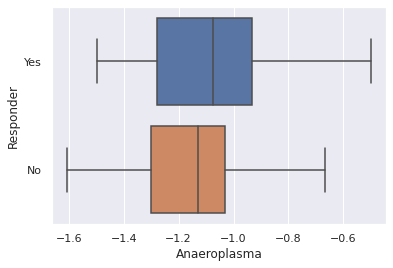

In [109]:
sns.boxplot(x='Anaeroplasma',y='Responder',data= clr_metadata_ML,showfliers=False)

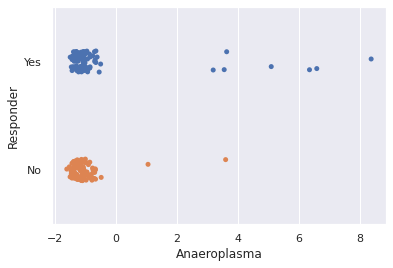

In [111]:
sns.stripplot(x='Anaeroplasma', y='Responder',data=clr_metadata_ML)

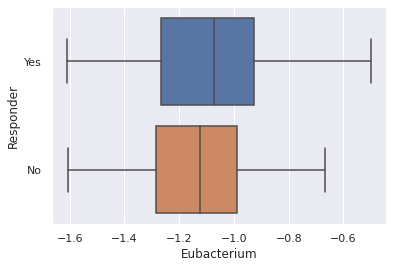

In [113]:
sns.boxplot(x='Eubacterium',y='Responder',data= clr_metadata_ML,showfliers=False)

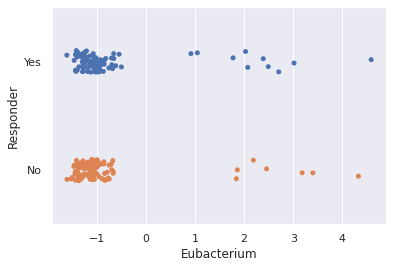

In [114]:
sns.stripplot(x='Eubacterium', y='Responder',data=clr_metadata_ML)

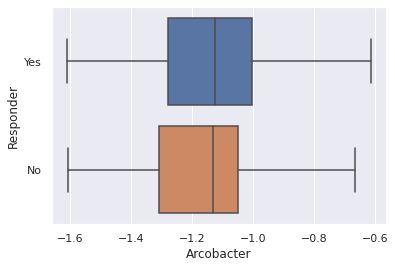

In [118]:
sns.boxplot(x='Arcobacter',y='Responder',data= clr_metadata_ML,showfliers=False)

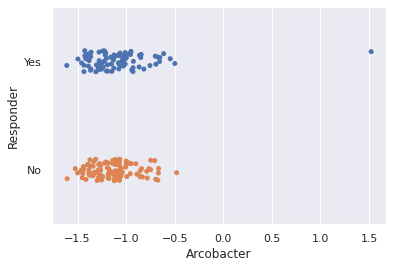

In [119]:
sns.stripplot(x='Arcobacter', y='Responder',data=clr_metadata_ML)

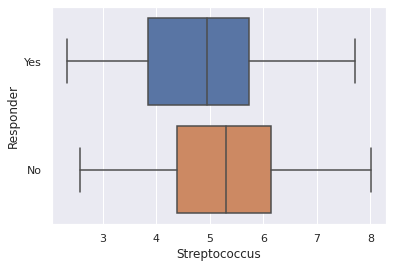

In [120]:
sns.boxplot(x='Streptococcus',y='Responder',data= clr_metadata_ML,showfliers=False)

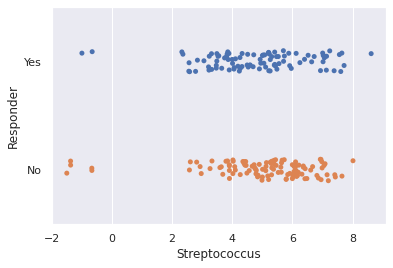

In [121]:
sns.stripplot(x='Streptococcus',y='Responder',data=clr_metadata_ML)

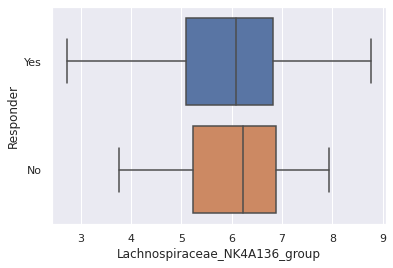

In [122]:
sns.boxplot(x='Lachnospiraceae_NK4A136_group',y='Responder',data=clr_metadata_ML,showfliers=False)

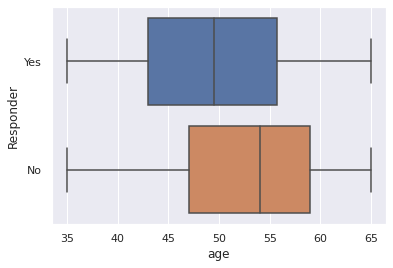

In [123]:
sns.boxplot(x='age',y='Responder',data=clr_metadata_ML,showfliers=False)

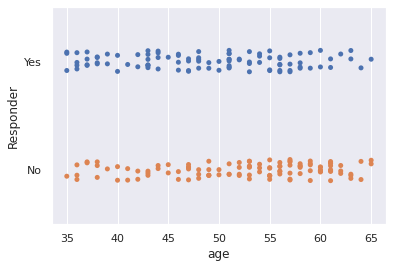

In [124]:
sns.stripplot(x='age',y='Responder',data=clr_metadata_ML)

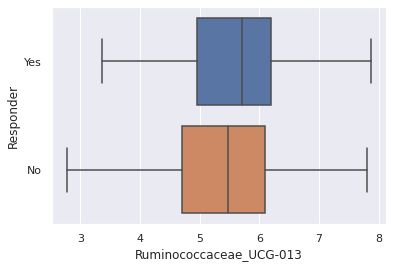

In [125]:
sns.boxplot(x='Ruminococcaceae_UCG-013',y='Responder',data=clr_metadata_ML,showfliers=False)

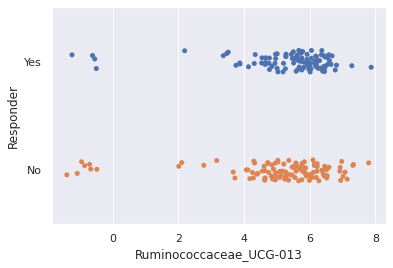

In [126]:
sns.stripplot(x='Ruminococcaceae_UCG-013',y='Responder',data=clr_metadata_ML)

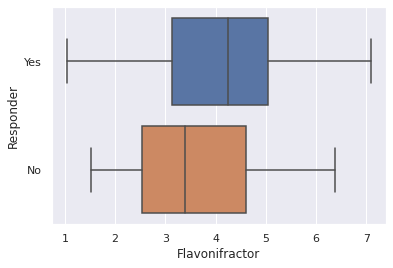

In [127]:
sns.boxplot(x='Flavonifractor',y='Responder',data=clr_metadata_ML,showfliers=False)

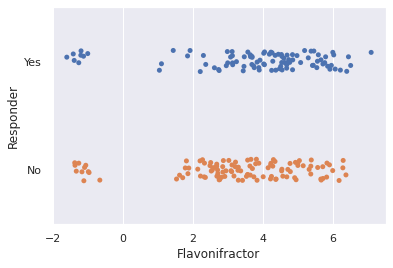

In [128]:
sns.stripplot(x='Flavonifractor',y='Responder',data=clr_metadata_ML)

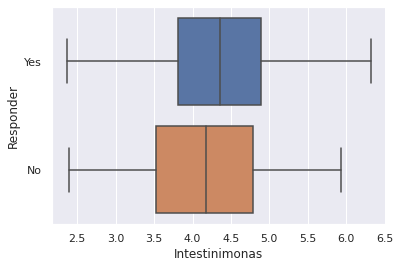

In [129]:
sns.boxplot(x='Intestinimonas',y='Responder',data=clr_metadata_ML,showfliers=False)

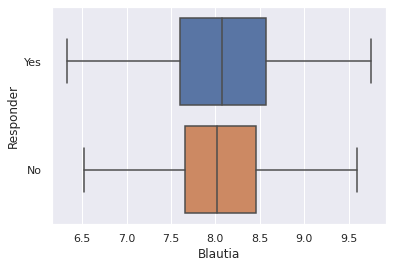

In [130]:
sns.boxplot(x='Blautia',y='Responder',data=clr_metadata_ML,showfliers=False)

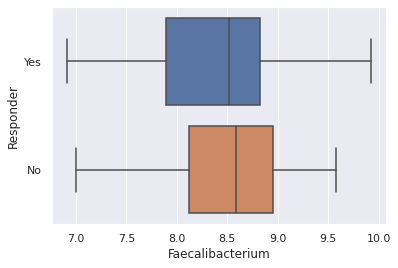

In [131]:
sns.boxplot(x='Faecalibacterium',y='Responder',data=clr_metadata_ML,showfliers=False)

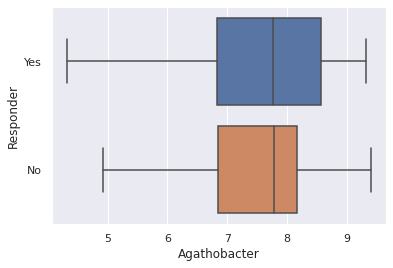

In [132]:
sns.boxplot(x='Agathobacter',y='Responder',data=clr_metadata_ML,showfliers=False)

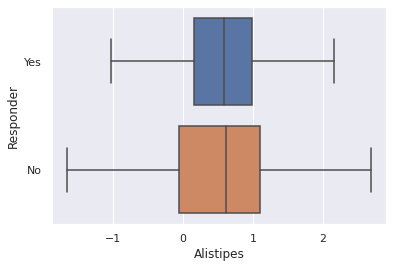

In [119]:
sns.boxplot(x='Alistipes',y='Responder',data=clr_metadata_ML,showfliers=False)

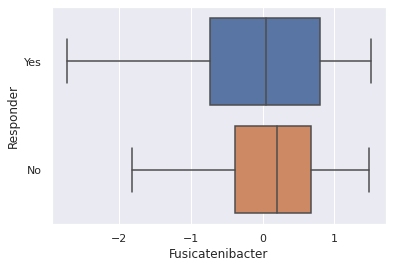

In [120]:
sns.boxplot(x='Fusicatenibacter',y='Responder',data=clr_metadata_ML,showfliers=False)

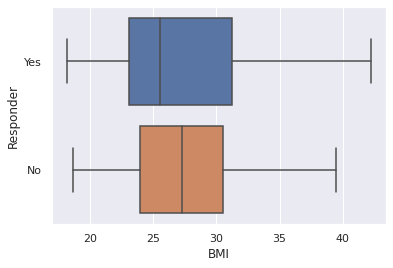

In [121]:
sns.boxplot(x='BMI',y='Responder',data=clr_metadata_ML,showfliers=False)

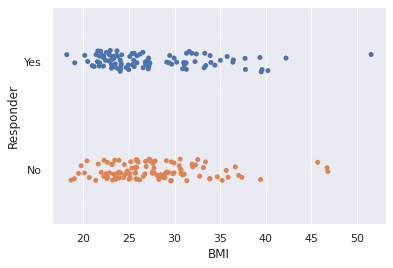

In [122]:
sns.stripplot(x='BMI',y='Responder',data=clr_metadata_ML)

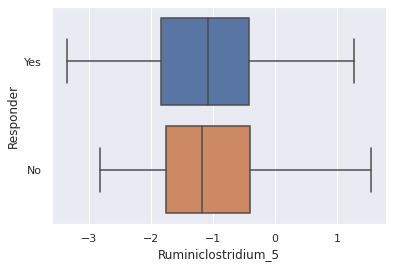

In [124]:
sns.boxplot(x='Ruminiclostridium_5',y='Responder',data=clr_metadata_ML,showfliers=False)

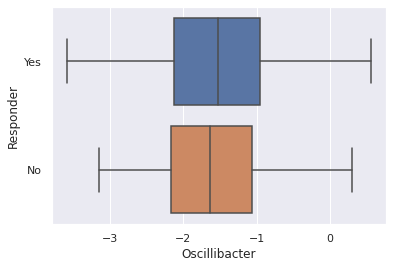

In [125]:
sns.boxplot(x='Oscillibacter',y='Responder',data=clr_metadata_ML,showfliers=False)

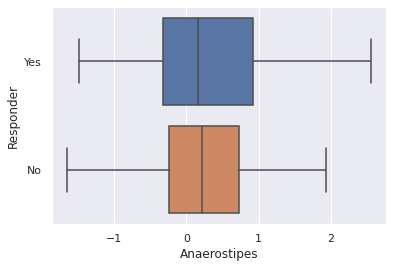

In [126]:
sns.boxplot(x='Anaerostipes',y='Responder',data=clr_metadata_ML,showfliers=False)

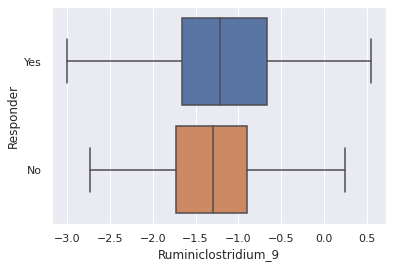

In [127]:
sns.boxplot(x='Ruminiclostridium_9',y='Responder',data=clr_metadata_ML,showfliers=False)

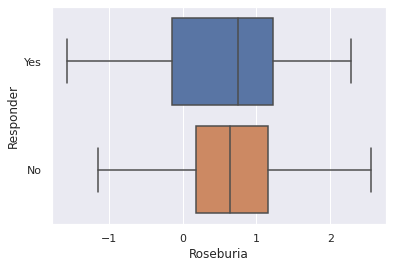

In [128]:
sns.boxplot(x='Roseburia',y='Responder',data=clr_metadata_ML,showfliers=False)

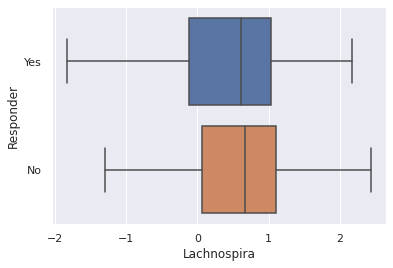

In [129]:
sns.boxplot(x='Lachnospira',y='Responder',data=clr_metadata_ML,showfliers=False)

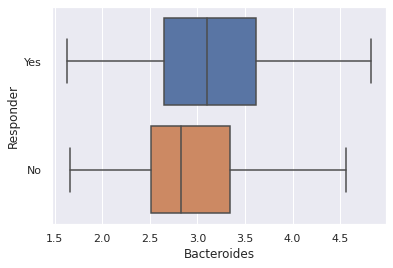

In [130]:
sns.boxplot(x='Bacteroides',y='Responder',data=clr_metadata_ML,showfliers=False)

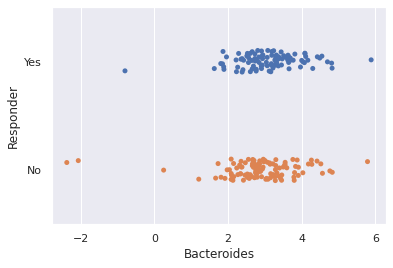

In [131]:
sns.stripplot(x='Bacteroides',y='Responder',data=clr_metadata_ML)

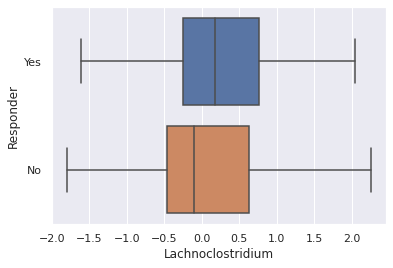

In [132]:
sns.boxplot(x='Lachnoclostridium',y='Responder',data=clr_metadata_ML,showfliers=False)

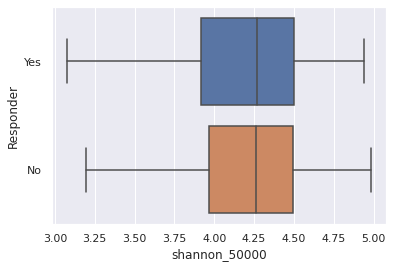

In [133]:
sns.boxplot(x='shannon_50000',y='Responder',data=clr_metadata_ML,showfliers=False)

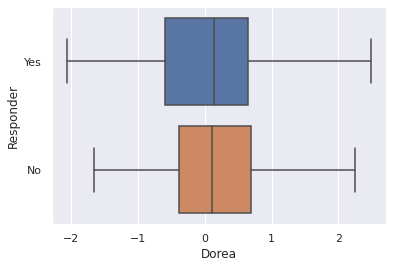

In [134]:
sns.boxplot(x='Dorea',y='Responder',data=clr_metadata_ML,showfliers=False)

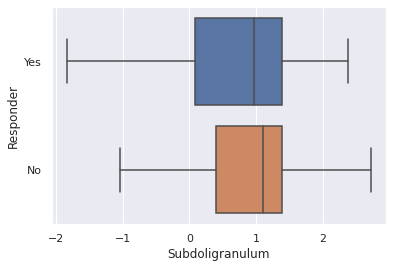

In [135]:
sns.boxplot(x='Subdoligranulum',y='Responder',data=clr_metadata_ML,showfliers=False)

In [133]:
#####################################
# constructing continuous ML data

In [134]:
continuous_data = clr_metadata_all.drop(['sample_id',
 'has_research_consent',
 'BL_time_point',
 'meds_antibiotics_last_3_months',
 'days_since_first_draw_abs',
 'BL_HbA1C',
 '2nd_time_point',
 '2nd_HbA1C',
 'Delta',
 'Delta2',
 'public_client_id',
 'Residuals',
 'Responder_new'],axis=1)
#list(continuous_data.columns)

In [135]:
#ml_cont_data = continuous_data.drop(['sample_id','public_client_id','has_research_consent','meds_antibiotics_last_3_months',
 #'days_since_first_draw_abs','BL_HbA1C','6mo_time_point','BL_time_point','2yr_HbA1C',
              #'Delta','Delta2','Residuals'],axis=1)
ml_cont_data = continuous_data.rename(columns={'ContResiduals':'Target'})

In [136]:
# create a dummy variable for Sex column in clr_metadata_all (female=1)
gender_ml = pd.get_dummies(ml_cont_data['sex'],drop_first=True)

# create a dummy variable for Responder column in clr_metadata_all table (responder=1)
#responder_ml = pd.get_dummies(ml_cont_data['Responder_new'],drop_first=True)


# concatenate the dummy variable table with the 
ml_microbiome2 = pd.concat([ml_cont_data,gender_ml],axis=1)
ml_microbiome2 = ml_microbiome2.rename(columns={'M':'Gender'}).drop(['sex'],axis=1)


In [137]:
X2 = ml_microbiome2.drop(['Target'],axis=1)
y2 = ml_microbiome2['Target']

In [138]:
X2_train,X2_test,y2_train,y2_test=train_test_split(X2,y2, test_size=0.2, random_state=101)

In [139]:
continuous_data.shape

(379, 426)

In [140]:
#########################
# CONTINUOUS MODEL 3: L1 LINEAR REGRESSION (LASSO)

In [141]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [142]:
continuous_lasso = Lasso(alpha=0.1,max_iter=10e5)

In [143]:
continuous_lasso.fit(X2_train,y2_train)

Lasso(alpha=0.1, max_iter=1000000.0)

In [144]:
ypred_contlasso = continuous_lasso.predict(X2_test)

Text(0.5, 1.0, 'Lasso Regression Results')

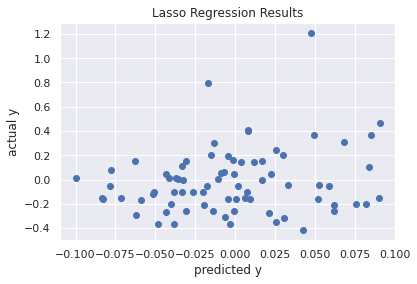

In [145]:
plt.scatter(ypred_contlasso,y2_test)
plt.ylabel('actual y')
plt.xlabel('predicted y')
plt.title('Lasso Regression Results')

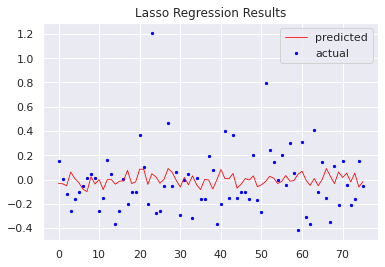

In [146]:
x_ax = range(len(X2_test))
plt.scatter(x_ax, y2_test, s=5, color="blue", label="actual")
plt.plot(x_ax, ypred_contlasso,lw=0.8, color="red", label="predicted")
plt.title('Lasso Regression Results')
plt.legend(loc=1)
plt.show()

In [147]:
print('RSME lasso regression:',np.sqrt(mean_squared_error(y2_test,ypred_contlasso)))
print('r2 score lasso regression:',r2_score(y2_test,ypred_contlasso))

RSME lasso regression: 0.26170643679940414
r2 score lasso regression: 0.034670602146881446


In [148]:
############################
# MODEL 4: Random Forest Regression

In [149]:
from sklearn.ensemble import RandomForestRegressor

In [150]:
features_list = list(X2.columns)

In [151]:
continuous_rf = RandomForestRegressor(n_estimators=1000,random_state=42)

In [152]:
continuous_rf.fit(X2_train,y2_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [153]:
ypred_contrf = continuous_rf.predict(X2_test)

Text(0.5, 1.0, 'Random Forest Regression Results')

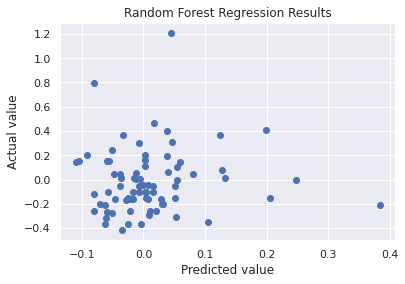

In [154]:
plt.scatter(ypred_contrf,y2_test)
plt.xlabel('Predicted value')
plt.ylabel('Actual value')
plt.title('Random Forest Regression Results')

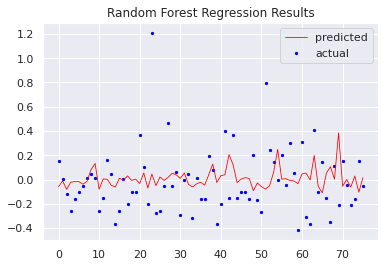

In [155]:
x_ax = range(len(X2_test))
plt.scatter(x_ax, y2_test, s=5, color="blue", label="actual")
plt.plot(x_ax, ypred_contrf,lw=0.8, color="red", label="predicted")
plt.title('Random Forest Regression Results')
plt.legend(loc=1)
plt.show()

In [156]:
print('RSME random forest regression:',np.sqrt(mean_squared_error(y2_test,ypred_contrf)))
print('r2 score random forest regression:',r2_score(y2_test,ypred_contrf))

RSME random forest regression: 0.27487102631334087
r2 score random forest regression: -0.06488976123818824


In [160]:
ml_microbiome2.shape

(379, 426)

In [161]:
############################
# UNIVARIATE ANALYSIS FOR R2 VALUES 

In [168]:
# defining features for univariate analyses
univariate_features = ml_microbiome2.drop(['Target'],axis=1)

# defining target for univariate analyses
univariate_target = ml_microbiome2['Target']

In [173]:
# for loop that calculates each r2 score for each feature 
r2_scores = []
pvalues = []
for column in univariate_features.columns:
    X_uni = univariate_features[column]
    y_uni = univariate_target
    X_uni = sm.add_constant(X_uni,prepend=False)
    uni_model = sm.OLS(y_uni,X_uni).fit()
    uni_pred = uni_model.predict(X_uni)
    #print(uni_model.summary())
    score = uni_model.rsquared
    pval = uni_model.pvalues
    r2_scores.append(score)
    pvalues.append(pval)
    

In [183]:
# extracting pvalues
pval_only = []
for i in range(0,425):
    p = pvalues[i][0]
    pval_only.append(p)

len(pval_only)

425

In [191]:
# combining features, r2 score and p value into a dataframe
features_uni = univariate_features.columns.tolist()
r2_score_uni = r2_scores
pvalues_uni = pval_only

r2_scores_df = pd.DataFrame({'feature':features_uni,'R2 score':r2_score_uni,'p value':pvalues_uni})
r2_scores_df.shape
# sort by r2 score
top_features = r2_scores_df.sort_values(by='p value',ascending=False)
top_features

feature      R2 score   p value
188              Mitsuokella  4.366413e-07  0.989770
180             Libanicoccus  8.057443e-07  0.986104
202          Corynebacterium  9.578913e-07  0.984849
95               Oxalobacter  1.254840e-06  0.982659
13   Ruminococcaceae_UCG-013  2.657310e-06  0.974767
..                       ...           ...       ...
422            shannon_50000  2.532796e-02  0.001884
421                      age  3.964482e-02  0.000095
6           Faecalibacterium  4.171512e-02  0.000062
232                  Proteus  5.410867e-02  0.000005
256               Morganella  5.923405e-02  0.000002

[425 rows x 3 columns]

In [193]:
from scipy.stats import pearsonr

In [195]:
# calculate Pearson coefficient and p-value for age
Xp1 = ml_microbiome2['age']
yp1 = ml_microbiome2['Target']
corr = pearsonr(Xp1,yp1)
print(corr)

(-0.19911008054702847, 9.516459655624593e-05)


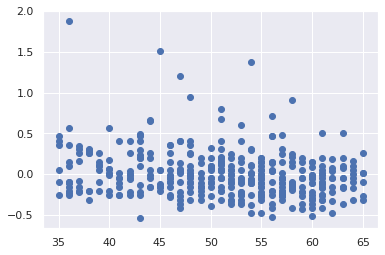

In [196]:
# plot age vs. target
plt.scatter(Xp1,yp1)
plt.show()

In [213]:
###########
# OLS LINEAR REGRESSION CONTROLLING AGE + BMI

In [243]:
genera_only = ml_microbiome2.drop(['age','BMI','Target'],axis=1)
genera_target = ml_microbiome2['Target']

In [241]:
import statsmodels.formula.api as smf

In [248]:
r2scores_ols = []
pvalues_ols = []

for genera in genera_only.columns:

    X_ols = ml_microbiome2[['age','BMI',genera]]
    y_ols = genera_target
    X_ols = sm.add_constant(X_ols,prepend=False)
    ols_model = sm.OLS(y_ols,X_ols).fit()
    ols_pred = ols_model.predict(X_ols)
    #print(uni_model.summary())
    score = ols_model.rsquared
    pval = ols_model.pvalues
    r2scores_ols.append(score)
    pvalues_ols.append(pval)

In [251]:
len(pvalues_ols)

423

In [254]:
pval_only_ols = []
for i in range(0,423):
    pval2 = pvalues_ols[i][2]
    pval_only_ols.append(pval2)

In [255]:
features_ols = genera_only.columns.tolist()
r2_score_ols = r2scores_ols
pvalues_ols = pval_only_ols
r2_scores_df_ols = pd.DataFrame({'feature':features_ols,'R2 score':r2_score_ols,'p value':pvalues_ols})

top_r2scores_ols = r2_scores_df_ols.sort_values(by='p value',ascending=True)
top_r2scores_ols

feature  R2 score   p value
6                Faecalibacterium  0.099440  0.000005
256                    Morganella  0.098582  0.000006
232                       Proteus  0.096841  0.000009
35   Lachnospiraceae_ND3007_group  0.073683  0.001342
37   Lachnospiraceae_FCS020_group  0.071283  0.002274
..                            ...       ...       ...
128                  Harryflintia  0.047897  0.979241
121           Ruminiclostridium_1  0.047896  0.991233
137       Lachnospiraceae_UCG-003  0.047895  0.993791
368        Candidatus_Arthromitus  0.047895  0.995061
187                     Weissella  0.047895  0.995565

[423 rows x 3 columns]

In [260]:
# calculating target residuals
target_resid_model = smf.ols(formula='Target ~ age + BMI', data=ml_microbiome2)
results = target_resid_model.fit()
target_resid = results.resid

In [257]:
# convert these to a list
target_resid_list = target_resid.tolist()

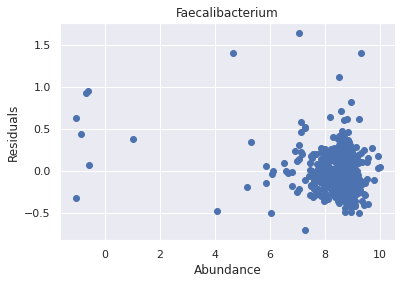

In [263]:
# plot abundance vs residuals for top 5 gut genera 
Xols_1 = ml_microbiome2['Faecalibacterium']
yols_1 = target_resid_list
corr1 = pearsonr(Xols_1,yols_1)

plt.scatter(Xols_1,yols_1)
plt.xlabel('Abundance')
plt.ylabel('Residuals')
plt.title('Faecalibacterium')
plt.show()

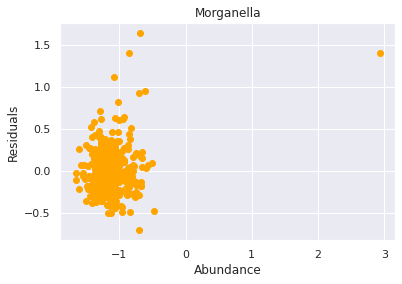

In [264]:
Xols_2 = ml_microbiome2['Morganella']
yols_2 = target_resid_list
corr2 = pearsonr(Xols_2,yols_2)

plt.scatter(Xols_2,yols_2,color='orange')
plt.xlabel('Abundance')
plt.ylabel('Residuals')
plt.title('Morganella')
plt.show()

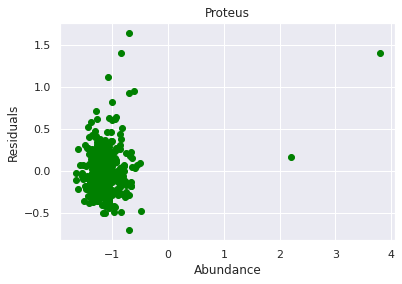

In [265]:
Xols_3 = ml_microbiome2['Proteus']
yols_3 = target_resid_list
corr3 = pearsonr(Xols_3,yols_3)

plt.scatter(Xols_3,yols_3,color='green')
plt.xlabel('Abundance')
plt.ylabel('Residuals')
plt.title('Proteus')
plt.show()

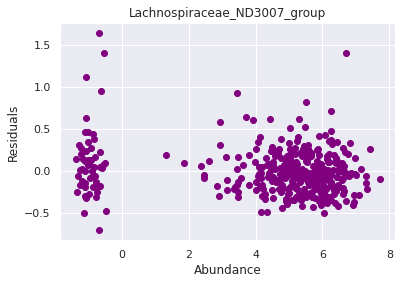

In [266]:
Xols_4 = ml_microbiome2['Lachnospiraceae_ND3007_group']
yols_4 = target_resid_list
corr4 = pearsonr(Xols_4,yols_4)

plt.scatter(Xols_4,yols_4,color='purple')
plt.xlabel('Abundance')
plt.ylabel('Residuals')
plt.title('Lachnospiraceae_ND3007_group')
plt.show()

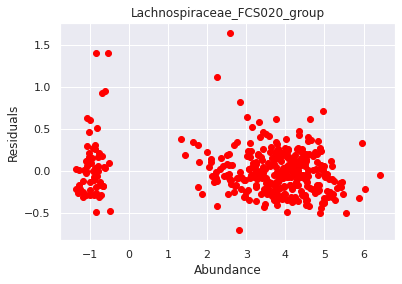

In [268]:
Xols_5 = ml_microbiome2['Lachnospiraceae_FCS020_group']
yols_5 = target_resid_list
corr5 = pearsonr(Xols_5,yols_5)

plt.scatter(Xols_5,yols_5,color='red')
plt.xlabel('Abundance')
plt.ylabel('Residuals')
plt.title('Lachnospiraceae_FCS020_group')
plt.show()